
# Create an image generator for training a computer vision model

## What I’m trying to do

I wanted a very simple end-to-end experiment: **generate my own dataset**, train a small image classifier on it, and see if training on synthetic data actually helps.

The task is intentionally basic: classify **two kinds of road signs**:

* **Stop sign**
* **Warning sign**

So the idea is:

1. generate images with a diffusion model,
2. save them in a clean dataset structure,
3. train a PyTorch model,
4. compare results **before vs after training**.

---

## What we did in this notebook

### 1) Generate a tiny synthetic dataset

I use a text-to-image diffusion pipeline and prompts like:

* “Generate a stop sign on the road…”
* “Generate a warning sign on the road…”

To keep it simple (and fast), I generated:

* **50 stop sign images**
* **50 warning sign images**

I save everything directly into folders that PyTorch can read easily (`ImageFolder`).

---

### 2) Save the dataset to Google Drive (Colab-friendly)

Since I’m working on Colab and runtimes can reset, I save the dataset on Drive so I don’t lose it.

The dataset is organized like this:

```
data/
  train/
    stop/
    warning/
  val/
    stop/
    warning/
```

---

### 3) Train a basic image classifier (PyTorch)

For the model, I went with a simple baseline that works well:

* **ResNet18** with a 2-class head (stop vs warning)

Training setup is straightforward:

* resize images to 224×224
* normalize
* CrossEntropyLoss + Adam
* train loop + validation loop

---

### 4) Compare “before” vs “after”

This is the part I really care about: I want a real comparison.

So I evaluate the model:

* **before training** (just the model setup, no fine-tuning yet)
* **after training** (trained on the synthetic dataset)

Then I plot:

* validation accuracy across epochs
* train/val loss curves
  (and optionally confusion matrix)

This makes it easy to see if training on artificial data helped or not.

---

### 5) Quick real-world test (inference on web images)

Just to make it more fun / realistic, I also test the model on **a couple of real road photos from the internet**, and I display:

* the image
* the predicted label (stop vs warning)
* the confidence score

This also gives a first look at the “synthetic → real” gap (usually the tricky part).

---

## Two test images will be used

* 1 road photo with a **STOP** sign
* 1 road photo with a **WARNING** sign

---

## Next steps (later)

If I continue this project, I’d probably:

* generate more variety (lighting, angle, distance, weather)
* increase dataset size
* test on a small real dataset to measure generalization properly



# Model Selection for diffusion

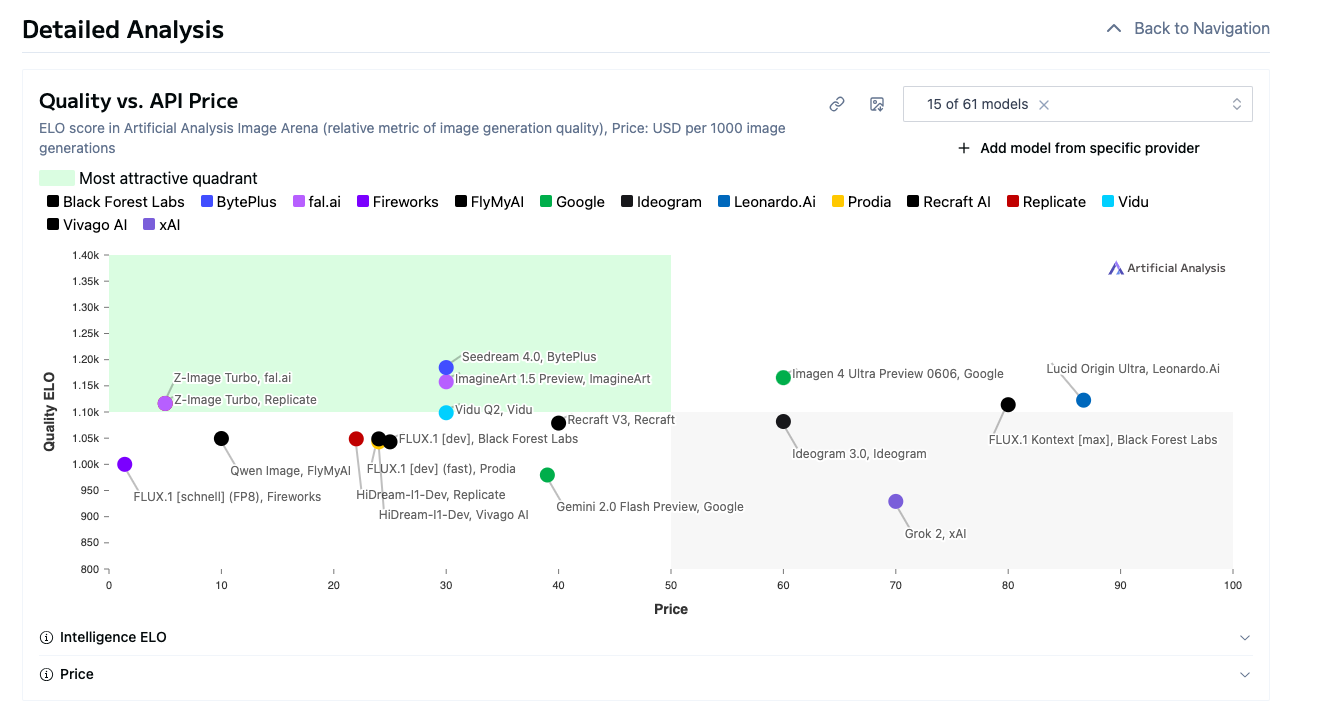

# Set up
GPU: Nvidia L4


In [ ]:
!pip install git+https://github.com/huggingface/diffusers


  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-a10ntmlf
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-a10ntmlf
  Resolved https://github.com/huggingface/diffusers to commit ca79f8ccc4856c675d189b6100dfbd971ea9d1b9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.37.0.dev0-py3-none-any.whl size=4940664 sha256=4f5bf9ce20bc97548bb74eec63c80ca24d346e40b023ed7e44809bd103268ec2
  Stored in directory: /tmp/pip-ephem-wheel-cache-mbcgk62u/wheels/90/d4/44/a58bc00fb405fefb633b0d9d2307f6e3aec6cc1775d82555d3
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.36.0
    Uninstalling diffusers-0.36.0:
      Successfully uninstalled diffusers-0.36.0


# Load the models

In [ ]:
import torch
from diffusers import ZImagePipeline

# 1. Load the pipeline
# Use bfloat16 for optimal performance on supported GPUs
pipe = ZImagePipeline.from_pretrained(
    "Tongyi-MAI/Z-Image-Turbo",
    torch_dtype=torch.bfloat16,
    low_cpu_mem_usage=False,
)
pipe.to("cuda")


prompt = "Generate a stop sign on the road"

# 2. Generate Image
image = pipe(
    prompt=prompt,
    height=1024,
    width=1024,
    num_inference_steps=9,  # This actually results in 8 DiT forwards
    guidance_scale=0.0,     # Guidance should be 0 for the Turbo models
    generator=torch.Generator("cuda").manual_seed(42),
).images[0]

image.save("example.png")


Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


model_index.json:   0%|          | 0.00/467 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_DIR = "/content/drive/MyDrive/sign_dataset"


In [ ]:
import os
import random
import torch

BASE_DIR = "/content/drive/MyDrive/sign_dataset"

def ensure_dirs(base=BASE_DIR):
    for split in ["train", "val"]:
        for cls in ["stop", "warning"]:
            os.makedirs(os.path.join(base, split, cls), exist_ok=True)

def make_prompt(sign_type: str) -> str:
    if sign_type == "stop":
        variants = [
            "Generate a realistic stop sign on the side of a road, daylight, street photo",
            "Generate a stop sign at an intersection, realistic photo, urban street",
            "Generate a stop sign near a pedestrian crossing, realistic street photo",
            "Generate a stop sign on a suburban road, realistic photo",
        ]
    else:
        variants = [
            "Generate a realistic warning road sign on the side of a road, daylight, street photo",
            "Generate a warning road sign near a curve, realistic photo",
            "Generate a warning road sign near a construction area, realistic street photo",
            "Generate a warning road sign on a suburban road, realistic photo",
        ]
    return random.choice(variants)

def generate_class_images(
    pipe,
    sign_type: str,
    n_total: int = 50,
    base_dir: str = BASE_DIR,
    img_size: int = 512,
    steps: int = 9,
    guidance: float = 0.0,
    seed_start: int = 10_000,
    val_ratio: float = 0.2,
):
    n_val = int(n_total * val_ratio)
    n_train = n_total - n_val

    seeds = list(range(seed_start, seed_start + n_total))
    random.shuffle(seeds)

    splits = (["train"] * n_train) + (["val"] * n_val)
    random.shuffle(splits)

    for i in range(n_total):
        split = splits[i]
        seed = seeds[i]
        prompt = make_prompt(sign_type)

        generator = torch.Generator(device="cuda").manual_seed(seed)

        img = pipe(
            prompt=prompt,
            height=img_size,
            width=img_size,
            num_inference_steps=steps,
            guidance_scale=guidance,
            generator=generator,
        ).images[0]

        out_path = os.path.join(base_dir, split, sign_type, f"{sign_type}_{i:03d}_seed{seed}.png")
        img.save(out_path)

        if (i + 1) % 10 == 0:
            print(f"[{sign_type}] generated {i+1}/{n_total} -> {out_path}")

# RUN
ensure_dirs(BASE_DIR)
generate_class_images(pipe, "stop",    n_total=50, seed_start=1000, img_size=512)
generate_class_images(pipe, "warning", n_total=50, seed_start=2000, img_size=512)

print("Done. Saved to:", BASE_DIR)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[stop] generated 10/50 -> /content/drive/MyDrive/sign_dataset/val/stop/stop_009_seed1011.png


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[stop] generated 20/50 -> /content/drive/MyDrive/sign_dataset/train/stop/stop_019_seed1021.png


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[stop] generated 30/50 -> /content/drive/MyDrive/sign_dataset/train/stop/stop_029_seed1003.png


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[stop] generated 40/50 -> /content/drive/MyDrive/sign_dataset/train/stop/stop_039_seed1020.png


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[stop] generated 50/50 -> /content/drive/MyDrive/sign_dataset/train/stop/stop_049_seed1029.png


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[warning] generated 10/50 -> /content/drive/MyDrive/sign_dataset/train/warning/warning_009_seed2040.png


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[warning] generated 20/50 -> /content/drive/MyDrive/sign_dataset/train/warning/warning_019_seed2042.png


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[warning] generated 30/50 -> /content/drive/MyDrive/sign_dataset/val/warning/warning_029_seed2011.png


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[warning] generated 40/50 -> /content/drive/MyDrive/sign_dataset/val/warning/warning_039_seed2002.png


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

[warning] generated 50/50 -> /content/drive/MyDrive/sign_dataset/train/warning/warning_049_seed2043.png
Done. Saved to: /content/drive/MyDrive/sign_dataset


In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

DATA_DIR = "/content/drive/MyDrive/sign_dataset"  # adapte si besoin
BATCH_SIZE = 32
IMG_SIZE = 224
NUM_WORKERS = 2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"),   transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Classes:", train_ds.classes)
print("Train:", len(train_ds), "Val:", len(val_ds))


Classes: ['stop', 'warning']
Train: 80 Val: 20


In [ ]:
import torch.nn.functional as F

def build_model(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total, correct = 0, 0
    loss_sum = 0.0

    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = criterion(logits, y)

        loss_sum += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    return loss_sum / total, correct / total

model = build_model(num_classes=len(train_ds.classes)).to(DEVICE)
criterion = nn.CrossEntropyLoss()

# Perf AVANT entraînement
val_loss_before, val_acc_before = evaluate(model, val_loader, criterion)
print(f"Before training | val_loss={val_loss_before:.4f} | val_acc={val_acc_before:.3f}")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 227MB/s]


Before training | val_loss=0.6582 | val_acc=0.600


In [ ]:
EPOCHS = 8
LR = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    total = 0

    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        total += y.size(0)

    train_loss = running_loss / total
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    history.append((epoch, train_loss, val_loss, val_acc))
    print(f"Epoch {epoch}/{EPOCHS} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_acc={val_acc:.3f}")

# Perf APRÈS entraînement
val_loss_after, val_acc_after = evaluate(model, val_loader, criterion)
print("\n--- Summary ---")
print(f"Before: val_loss={val_loss_before:.4f} | val_acc={val_acc_before:.3f}")
print(f"After : val_loss={val_loss_after:.4f} | val_acc={val_acc_after:.3f}")

# Sauvegarde sur Drive
CKPT_PATH = "/content/drive/MyDrive/sign_dataset_resnet18.pt"
torch.save(model.state_dict(), CKPT_PATH)
print("Saved:", CKPT_PATH)


Epoch 1/8 | train_loss=0.3703 | val_loss=0.1151 | val_acc=0.950
Epoch 2/8 | train_loss=0.0195 | val_loss=0.0232 | val_acc=1.000
Epoch 3/8 | train_loss=0.0028 | val_loss=0.0049 | val_acc=1.000
Epoch 4/8 | train_loss=0.0011 | val_loss=0.0017 | val_acc=1.000
Epoch 5/8 | train_loss=0.0011 | val_loss=0.0008 | val_acc=1.000
Epoch 6/8 | train_loss=0.0005 | val_loss=0.0005 | val_acc=1.000
Epoch 7/8 | train_loss=0.0002 | val_loss=0.0005 | val_acc=1.000
Epoch 8/8 | train_loss=0.0002 | val_loss=0.0004 | val_acc=1.000

--- Summary ---
Before: val_loss=0.6582 | val_acc=0.600
After : val_loss=0.0004 | val_acc=1.000
Saved: /content/drive/MyDrive/sign_dataset_resnet18.pt


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def get_preds(model, loader):
    model.eval()
    all_y, all_p = [], []
    for x, y in loader:
        x = x.to(DEVICE)
        logits = model(x)
        p = logits.argmax(dim=1).cpu().numpy()
        all_p.append(p)
        all_y.append(y.numpy())
    return np.concatenate(all_y), np.concatenate(all_p)

y_true, y_pred = get_preds(model, val_loader)

print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
print("\nReport:\n", classification_report(y_true, y_pred, target_names=val_ds.classes))


Confusion matrix:
 [[10  0]
 [ 0 10]]

Report:
               precision    recall  f1-score   support

        stop       1.00      1.00      1.00        10
     warning       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



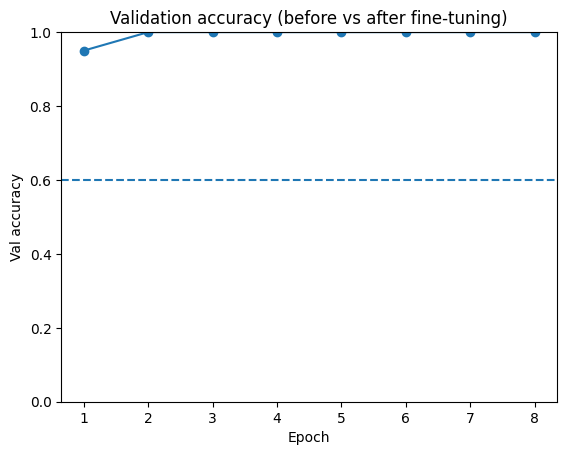

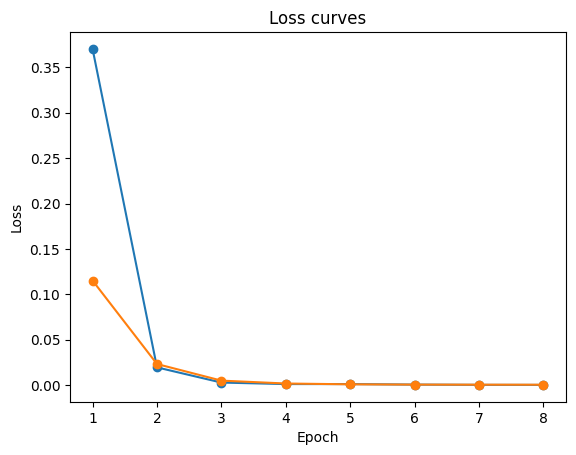

In [ ]:
import matplotlib.pyplot as plt

# history = [(epoch, train_loss, val_loss, val_acc), ...]
epochs    = [h[0] for h in history]
train_loss = [h[1] for h in history]
val_loss   = [h[2] for h in history]
val_acc    = [h[3] for h in history]

# 1) Accuracy val vs epochs + point "avant"
plt.figure()
plt.plot(epochs, val_acc, marker="o")
plt.axhline(y=val_acc_before, linestyle="--")
plt.title("Validation accuracy (before vs after fine-tuning)")
plt.xlabel("Epoch")
plt.ylabel("Val accuracy")
plt.ylim(0, 1.0)
plt.show()

# 2) Loss train/val vs epochs
plt.figure()
plt.plot(epochs, train_loss, marker="o")
plt.plot(epochs, val_loss, marker="o")
plt.title("Loss curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


# Test on image from the Web

Classes order: ['stop', 'warning']

STOP image:
  stop: 0.9327

WARNING image:
  stop: 0.1222


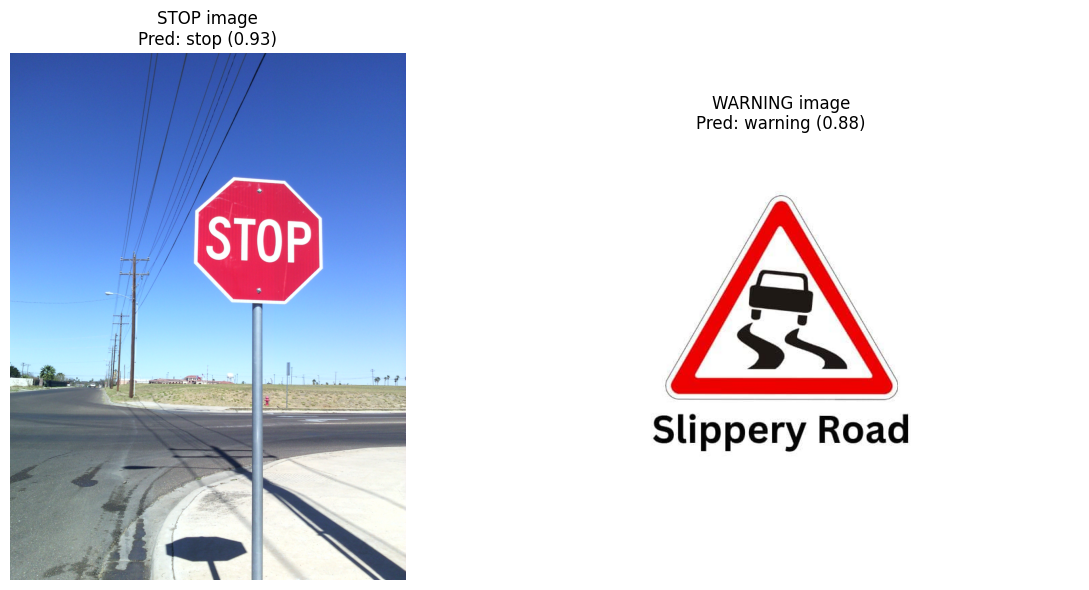

In [ ]:
import os, requests
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchvision import transforms, models, datasets

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DATA_DIR = "/content/drive/MyDrive/sign_dataset"
CKPT_PATH = "/content/drive/MyDrive/sign_dataset_resnet18.pt"

# 1) Récupérer l'ordre des classes EXACT (important)
tmp_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"))
classes = tmp_ds.classes
print("Classes order:", classes)  # ex: ['stop', 'warning']

# 2) Reconstruire le modèle + charger les poids
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# 3) Preprocess identique à l'entraînement
tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

test_urls = [
    ("STOP image", "https://jooinn.com/images/stop-sign-2.jpg"),
    ("WARNING image", "https://driveeuae.com/_next/image/?q=75&url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fyfo7nms9%2Fproduction%2F171460b2d13ac9cc007a380547b322904f2e5cfa-882x529.jpg&w=3840"),
]

os.makedirs("test_images", exist_ok=True)

def download(url, out_path):
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    with open(out_path, "wb") as f:
        f.write(r.content)

@torch.no_grad()
def predict(img_pil: Image.Image):
    x = tfms(img_pil).unsqueeze(0).to(DEVICE)
    logits = model(x)
    probs = torch.softmax(logits, dim=1).squeeze(0).cpu()
    pred_idx = int(torch.argmax(probs))
    return pred_idx, probs

# 4) Affichage images + prédictions
plt.figure(figsize=(12, 6))
for i, (title, url) in enumerate(test_urls, start=1):
    path = f"test_images/test_{i}.jpg"
    download(url, path)

    img = Image.open(path).convert("RGB")
    pred_idx, probs = predict(img)
    pred_class = classes[pred_idx]
    conf = float(probs[pred_idx])

    ax = plt.subplot(1, 2, i)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(f"{title}\nPred: {pred_class} ({conf:.2f})")

    # imprime aussi les probs détaillées
    print(f"\n{title}:")
    for c, p in zip(classes, probs.tolist()):
        print(f"  {c}: {p:.4f}")

plt.tight_layout()
plt.show()

